Time Series LSTM
----
Multivariate Multi-lag Timestep Single Output Forecast

In [ ]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
# Highly recommended for time series data
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
# Processing and metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
# keras --2019--> tf.keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Raw Data Cleaning
----
Beijing PM2.5 dataset: Hourly pollution data

In [ ]:
from datetime import datetime
# load data
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('raw.csv', index_col=0)
print(dataset.head(10))
dataset = read_csv('raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
print(dataset.head(5))
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('pollution.csv')

    year  month  day  hour  pm2.5  DEWP  TEMP    PRES cbwd    Iws  Is  Ir
No                                                                       
1   2010      1    1     0    NaN   -21 -11.0  1021.0   NW   1.79   0   0
2   2010      1    1     1    NaN   -21 -12.0  1020.0   NW   4.92   0   0
3   2010      1    1     2    NaN   -21 -11.0  1019.0   NW   6.71   0   0
4   2010      1    1     3    NaN   -21 -14.0  1019.0   NW   9.84   0   0
5   2010      1    1     4    NaN   -20 -12.0  1018.0   NW  12.97   0   0
                     No  pm2.5  DEWP  TEMP    PRES cbwd    Iws  Is  Ir
year_month_day_hour                                                   
2010-01-01 00:00:00   1    NaN   -21 -11.0  1021.0   NW   1.79   0   0
2010-01-01 01:00:00   2    NaN   -21 -12.0  1020.0   NW   4.92   0   0
2010-01-01 02:00:00   3    NaN   -21 -11.0  1019.0   NW   6.71   0   0
2010-01-01 03:00:00   4    NaN   -21 -14.0  1019.0   NW   9.84   0   0
2010-01-01 04:00:00   5    NaN   -20 -12.0  1018.0   NW 

Quick view on cleaned data
----

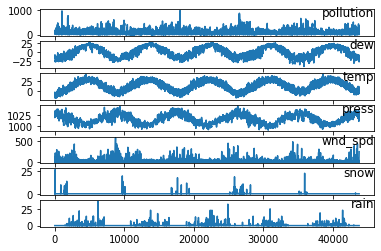

,pollution,dew,temp,press,wnd_spd,snow,rain
count,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000
mean,94.013516,1.828516,12.459041,1016.447306,23.894307,0.052763,0.195023
std,92.252276,14.429326,12.193384,10.271411,50.022729,0.760582,1.416247
min,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,24.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,68.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,132.250000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


In [ ]:
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()
dataset.describe() # Awesome for data summary!

Data Processing
----
* Encode categorical data
* Scaling
* *series_to_supervised()*

In [ ]:
# prepare data for lstm

# convert series to supervised learning  --> stride?
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1): # shift to hist. according to n_in
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out): # shift to future according to n_out
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4]) # Wind Dir
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict (everything except pollution)
print("Before Drop:")
print(reframed.head())
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print("After Drop:")
print(reframed.head())

Before Drop:
   var1(t-1)  var2(t-1)  var3(t-1)  ...   var6(t)   var7(t)  var8(t)
1   0.129779   0.352941   0.245902  ...  0.003811  0.000000      0.0
2   0.148893   0.367647   0.245902  ...  0.005332  0.000000      0.0
3   0.159960   0.426471   0.229508  ...  0.008391  0.037037      0.0
4   0.182093   0.485294   0.229508  ...  0.009912  0.074074      0.0
5   0.138833   0.485294   0.229508  ...  0.011433  0.111111      0.0

[5 rows x 16 columns]
After Drop:
   var1(t-1)  var2(t-1)  var3(t-1)  ...  var7(t-1)  var8(t-1)   var1(t)
1   0.129779   0.352941   0.245902  ...   0.000000        0.0  0.148893
2   0.148893   0.367647   0.245902  ...   0.000000        0.0  0.159960
3   0.159960   0.426471   0.229508  ...   0.000000        0.0  0.182093
4   0.182093   0.485294   0.229508  ...   0.037037        0.0  0.138833
5   0.138833   0.485294   0.229508  ...   0.074074        0.0  0.109658

[5 rows x 9 columns]


Train-Test Split
----
**Data dimension:**
* X: [num_samples, timesteps (aka lag), features (aka num. variables)] 
* Y: [num_samples, ]

In [ ]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24 # One year worth training data
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [num_samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1])) # timestep = 1 (lag)
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


Define and Train Model
----

Epoch 1/50
122/122 - 34s - loss: 0.0574 - val_loss: 0.0512
Epoch 2/50
122/122 - 1s - loss: 0.0413 - val_loss: 0.0526
Epoch 3/50
122/122 - 1s - loss: 0.0258 - val_loss: 0.0485
Epoch 4/50
122/122 - 1s - loss: 0.0183 - val_loss: 0.0452
Epoch 5/50
122/122 - 1s - loss: 0.0163 - val_loss: 0.0295
Epoch 6/50
122/122 - 1s - loss: 0.0151 - val_loss: 0.0208
Epoch 7/50
122/122 - 1s - loss: 0.0148 - val_loss: 0.0186
Epoch 8/50
122/122 - 1s - loss: 0.0146 - val_loss: 0.0172
Epoch 9/50
122/122 - 1s - loss: 0.0146 - val_loss: 0.0163
Epoch 10/50
122/122 - 1s - loss: 0.0147 - val_loss: 0.0162
Epoch 11/50
122/122 - 1s - loss: 0.0146 - val_loss: 0.0158
Epoch 12/50
122/122 - 1s - loss: 0.0146 - val_loss: 0.0154
Epoch 13/50
122/122 - 1s - loss: 0.0146 - val_loss: 0.0150
Epoch 14/50
122/122 - 1s - loss: 0.0146 - val_loss: 0.0144
Epoch 15/50
122/122 - 1s - loss: 0.0145 - val_loss: 0.0143
Epoch 16/50
122/122 - 1s - loss: 0.0144 - val_loss: 0.0140
Epoch 17/50
122/122 - 1s - loss: 0.0146 - val_loss: 0.0139
Epoch

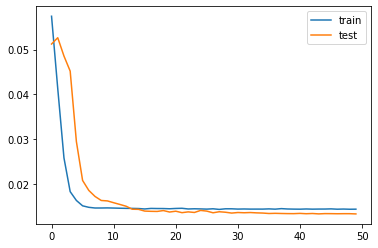

In [ ]:
...
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam') # Mean Absolute Error with Adam opt.
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Evaluation
----

In [ ]:
...
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.434


Multiple Lag Timestep Version
----

In [ ]:
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

#### 
# specify the number of lag hours
n_hours = 3 # Previously = 1
n_features = 8
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)
####

(43797, 32)


In [ ]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

####
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
####

(8760, 24) 8760 (8760,)
(8760, 3, 8) (8760,) (35037, 3, 8) (35037,)


Epoch 1/50
122/122 - 2s - loss: 0.0482 - val_loss: 0.0619
Epoch 2/50
122/122 - 1s - loss: 0.0251 - val_loss: 0.0430
Epoch 3/50
122/122 - 1s - loss: 0.0223 - val_loss: 0.0290
Epoch 4/50
122/122 - 1s - loss: 0.0214 - val_loss: 0.0278
Epoch 5/50
122/122 - 1s - loss: 0.0211 - val_loss: 0.0239
Epoch 6/50
122/122 - 1s - loss: 0.0200 - val_loss: 0.0218
Epoch 7/50
122/122 - 1s - loss: 0.0201 - val_loss: 0.0200
Epoch 8/50
122/122 - 1s - loss: 0.0194 - val_loss: 0.0187
Epoch 9/50
122/122 - 1s - loss: 0.0189 - val_loss: 0.0186
Epoch 10/50
122/122 - 1s - loss: 0.0183 - val_loss: 0.0182
Epoch 11/50
122/122 - 1s - loss: 0.0180 - val_loss: 0.0175
Epoch 12/50
122/122 - 1s - loss: 0.0174 - val_loss: 0.0176
Epoch 13/50
122/122 - 1s - loss: 0.0172 - val_loss: 0.0172
Epoch 14/50
122/122 - 1s - loss: 0.0167 - val_loss: 0.0174
Epoch 15/50
122/122 - 1s - loss: 0.0164 - val_loss: 0.0172
Epoch 16/50
122/122 - 1s - loss: 0.0158 - val_loss: 0.0175
Epoch 17/50
122/122 - 1s - loss: 0.0156 - val_loss: 0.0175
Epoch 

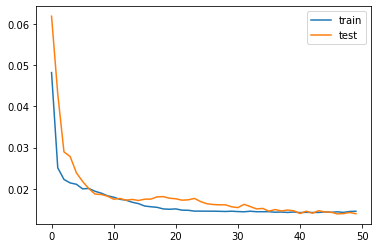

In [ ]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))

####
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
####

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

End of Demo
----
Credit to:
https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/